### Capstone Project - The Battle of Neighborhoods

# Best Place for Pet Store in Seattle

This analysis is part of my Applied Data Science Capstone course in Coursera. In this assignment I use my new skills in exploring, segmenting and clustering data and for the first time I prepare full report on my findings. Instruction for this assignment was to compare neighborhoods or cities and use Foursquare location data to solve a business problem. 

In my analysis I explore what would be the best place to establish a new pet store in Seattle.

#### Table of Contents:

1. Introduction - Description of the Problem
2. Data
3. Methodology
  - Import libraries
  - Seattle Zip Codes and Coordinates
  - Seattle Neighborhoods and Zip Codes
  - Seattle Pet Licenses
  - Merge the DataFrames: Zip Codes, Neighborhoods, Coordinates and Pet Licenses
  - Seattle Neighborhoods and Population
  - Segmenting and Analyzing the Seattle Neighborhoods
  - Other Pet Stores and Venues
4. Results
  - Seattle neighborhood with most pet licenses and population
  - The most popular venues in Seattle neighborhoods
  - Competitors and other pet related venues
5. Discussion
6. Conclusion


----

## 1. Introduction - Description of the Problem 

Pet owners are spending lots of money on their pets - their food, treats, toys and other supplies. According to the article of Directory of Major Malls pet owners in Unites States spent 500 dollars on their animals in 2017. In 2018 total pet sales was 72 billion dollars and in 2019 over 75 billion dollars. Retail pet stores are expanding their retail network by dozens of new stores around the nation and the total sales of pet stores is increasing every year and not likely to slow anytime soon.

Pet stores seem to be very profitable business. The city of Seattle has about 30 pet stores, 50 000 active pet licenses and 600 000 residents. Would there be room for another pet store? Where would it be? 

I’m exploring the possibilities in these viewpoints:

- How many active pet licenses there is in each neighborhood of Seattle? What is the population in these neighborhoods?
- What are the most popular venues in each neighborhood? 
- What about competitors? Are there other pet stores nearby?
- Are there other pet related venues that make one neighborhood more attractive than another?

This analysis can provide interesting observations for new entrepreneur starting a pet business or current pet stores that consider growing their retail network in Seattle. 

----

## 2. Data

I used four datasets in this analysis. 

1. **Seattle Pet Licenses.** Data includes 50 000 active pet licenses in Seattle, license issue dates, license numbers, species, animal’s names and owners’ zip codes. The data is hosted by the City of Seattle and updated quarterly. Dataset is available in Kaggle: https://www.kaggle.com/city-of-seattle/seattle-pet-licenses  


2. **US Zip Codes.** This dataset includes all zip codes in the US, states, counties and cities, coordinates and population data. I used this data to get the latitudes and longitudes of each zip code area and in exploring the population of Seattle neighborhoods. The dataset is available in three levels: basic, pro and comprehensive. For this analysis the free basic version contained enough data, so that is what I used. You can download the data here: https://simplemaps.com/data/us-zips


3. **ub-Regional, City and Neighborhood Designations by Zip Code.** This data is in pdf file and available here: http://www.agingkingcounty.org/wp-content/uploads/sites/185/2016/09/SubRegZipCityNeighborhood.pdf. I found it much faster to copy the tables that I needed to excel rather than read pdf file in python. The data includes zip codes, city names, sub regions and Seattle neighborhoods. This dataset was useful in finding the right neighborhood for each zip code.


4. **Foursquare location data.** I used Foursquare for exploring the venues in Seattle: the most popular venues, other pet stores and pet related venues. More about Foursquare here: https://foursquare.com/



----

## 3. Methodology

First, I explored how many pet licenses there is in each neighborhood of Seattle and what is the population in the neighborhoods. 

I started by cleaning the dataframes. From datasets "US Zip Code" and "Sub-regional, city and neighborhood designation by zip code" I took only the data that concerned Seattle: zip codes, coordinates and population. 

Also, the pet license dataset had lots of information, but the most important information for my analysis was the number of active licenses and the zip codes. I took only the licenses that were issued since 1st January 2010. The licenses in the dataset should be active, but some licenses were issued in 2000-2009. I found it safe to drop those licenses out from this analysis.

By merging these dataframes I could easily see the most populated neighborhood, the neighborhood that has most pet licenses and their coordinates.

Second, I segmented and analyzed the Seattle neighborhoods using Foursquare location data. 

I searched popular nearby venues in 5000 meters and limited the results in 500 venues. I had three goals: to find out what are the most popular venues in each neighborhood, is there other pet stores nearby and is there other pet related venues, for example dog runs. 

I knew that there would be lots of restaurants and cafés in popular venues, so with these limits I would get also pet shops for result.

Then I divided the most popular venues into five clusters and combined the data on neighborhoods, pet stores, parks and other pet venues in one dataframe. 

#### Import libraries

In [1]:
import numpy as np # Library to handle data in a vectorized manner
import pandas as pd # Library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # Library to handle requests
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe
import json # Library to handle JSON files

# Import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
# Visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# !conda install -c conda-forge folium

In [4]:
import folium
from folium import plugins

In [5]:
# !conda install -c conda-forge geopy

In [6]:
from geopy.geocoders import Nominatim

In [7]:
# Import my passwords for Foursquare
import os
import sys
sys.path.insert(0, os.path.abspath(os.environ['USERPROFILE'] + '/Desktop/riikka_pwd'))
import foursquare_pwd

---

#### Create DataFrame: Seattle Zip Codes and Coordinates

In [8]:
# Get the data 'uszips.csv'
df_uszips_all = pd.read_csv('uszips.csv')
df_uszips_all.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17242,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,38442,523.5,72003,Aguada,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,48814,667.9,72005,Aguadilla,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6437,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,27073,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico


In [9]:
df_uszips_all.shape

(33099, 18)

In [10]:
# Let's choose the rows where city name is Seattle and rename the dataframe
df_uszips_seattle = df_uszips_all.loc[df_uszips_all['city'] == 'Seattle']
df_uszips_seattle.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
32319,98101,47.61129,-122.33454,Seattle,WA,Washington,True,NaN,12792,7613.3,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles
32320,98102,47.63632,-122.32213,Seattle,WA,Washington,True,NaN,25448,6228.4,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles
32321,98103,47.67332,-122.34254,Seattle,WA,Washington,True,NaN,51377,3815.7,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles
32322,98104,47.60169,-122.32849,Seattle,WA,Washington,True,NaN,14144,6533.8,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles
32323,98105,47.66068,-122.28403,Seattle,WA,Washington,True,NaN,48861,4108.7,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles


In [11]:
# Let's take the columns we need
df_uszips_seattle = df_uszips_seattle[['zip','lat','lng']].reset_index(drop=True)
df_uszips_seattle.head()

,zip,lat,lng
0,98101,47.61129,-122.33454
1,98102,47.63632,-122.32213
2,98103,47.67332,-122.34254
3,98104,47.60169,-122.32849
4,98105,47.66068,-122.28403


In [12]:
# Rename the columns
df_uszips_seattle.rename(columns = {'zip': 'ZIP Code', 'lat':'Latitude', 'lng':'Longitude'}, inplace=True)
df_uszips_seattle.head()

,ZIP Code,Latitude,Longitude
0,98101,47.61129,-122.33454
1,98102,47.63632,-122.32213
2,98103,47.67332,-122.34254
3,98104,47.60169,-122.32849
4,98105,47.66068,-122.28403


In [13]:
df_uszips_seattle.shape

(38, 3)

---

#### Create DataFrame: Seattle Neighborhoods and Zip Codes

In [14]:
# Get the data 'Sub-Regional, City and Neighborhood Designations by Zip Code.xlsx'
df_neighborhoods = pd.read_excel('Sub-Regional, City and Neighborhood Designations by Zip Code.xlsx')
df_neighborhoods.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Sort by ZIP Code,NaN,NaN,NaN
1,ZIP,City Name,Sub Region,Seattle
2,NaN,NaN,NaN,Neighborhood
3,98001,Auburn,South Urban,NaN
4,98002,Auburn,South Urban,NaN


In [15]:
# Let's rename the columns
df_neighborhoods.rename(columns = {'Unnamed: 0':'ZIP Code', 
                                   'Unnamed: 1':'City Name', 
                                   'Unnamed: 2':'Sub Region', 
                                   'Unnamed: 3':'Seattle Neighborhood'}, inplace=True)

In [16]:
# Let's drop the first three rows by index
df_neighborhoods.drop([0, 1, 2], inplace=True)
df_neighborhoods.head()

,ZIP Code,City Name,Sub Region,Seattle Neighborhood
3,98001,Auburn,South Urban,NaN
4,98002,Auburn,South Urban,NaN
5,98003,Federal Way,South Urban,NaN
6,98004,Bellevue,East Urban,NaN
7,98005,Bellevue,East Urban,NaN


In [17]:
# Take rows where City Name contains 'Seattle'
df_neighborhoods_seattle = df_neighborhoods.loc[df_neighborhoods['City Name'].str.contains('Seattle')]
df_neighborhoods_seattle

,ZIP Code,City Name,Sub Region,Seattle Neighborhood
63,98101,Seattle,Seattle,Downtown
64,98102,Seattle,Seattle,Capitol Hill
65,98103,Seattle,Seattle,Lake Union
66,98104,Seattle,Seattle,Downtown
67,98105,Seattle,Seattle,Northeast
68,98106,Seattle,Seattle,Delridge
69,98107,Seattle,Seattle,Ballard
70,98108,Seattle,Seattle,Duwamish
71,98109,Seattle,Seattle,Queen Anne/Magnolia
72,98111,Seattle,Seattle,Downtown


In [18]:
df_neighborhoods_seattle.shape

(45, 4)

In [19]:
# If column Seattle Neighborhood is NaN, then the neighborhood will be the same as the Sub Region
df_neighborhoods_seattle['Seattle Neighborhood'].fillna(df_neighborhoods_seattle['Sub Region'], inplace=True)
df_neighborhoods_seattle.head()

C:\Users\U589514\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,ZIP Code,City Name,Sub Region,Seattle Neighborhood
63,98101,Seattle,Seattle,Downtown
64,98102,Seattle,Seattle,Capitol Hill
65,98103,Seattle,Seattle,Lake Union
66,98104,Seattle,Seattle,Downtown
67,98105,Seattle,Seattle,Northeast


In [20]:
# Choose columns zip code and Seattle Neighborhoods
df_seattle_neighborhoods = df_neighborhoods_seattle[['ZIP Code', 'Seattle Neighborhood']]
df_seattle_neighborhoods.head()

,ZIP Code,Seattle Neighborhood
63,98101,Downtown
64,98102,Capitol Hill
65,98103,Lake Union
66,98104,Downtown
67,98105,Northeast


---

#### Create DataFrame: Seattle Pet Licenses

In [21]:
# Get the data 'seattle-pet-licenses.csv'
df_licenses_all = pd.read_csv('seattle-pet-licenses.csv')
df_licenses_all.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,2000-01-03T00:00:00.000,263574,NaN,Dog,Shepherd,NaN,98119
1,2000-01-05T00:00:00.000,119820,Fancy,Dog,"Retriever, Labrador",NaN,98106
2,2000-01-06T00:00:00.000,10401,Skip,Dog,Siberian Husky,Mix,NaN
3,2000-01-12T00:00:00.000,941592,Kanga,Dog,German Shepherd,NaN,98107
4,2000-01-24T00:00:00.000,422763,Oscar,Dog,"Retriever, Golden",NaN,NaN


In [22]:
df_licenses_all.shape

(49230, 7)

In [23]:
# Let's change the 'License Issue Date' dtype to datetime
df_licenses_all['License Issue Date'] = pd.to_datetime(df_licenses_all['License Issue Date'])
df_licenses_all.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,2000-01-03,263574,NaN,Dog,Shepherd,NaN,98119
1,2000-01-05,119820,Fancy,Dog,"Retriever, Labrador",NaN,98106
2,2000-01-06,10401,Skip,Dog,Siberian Husky,Mix,NaN
3,2000-01-12,941592,Kanga,Dog,German Shepherd,NaN,98107
4,2000-01-24,422763,Oscar,Dog,"Retriever, Golden",NaN,NaN


In [24]:
# How many NaN we have in Zip Codes?
df_licenses_all['ZIP Code'].isnull().sum()

1214

In [25]:
# What is the amount of NaN in zip codes?
print('Percentage of all NaN zip codes: ', (df_licenses_all['ZIP Code'].isnull().sum() / len(df_licenses_all.index) *100).astype('int'), '%')

Percentage of all NaN zip codes:  2 %


In [26]:
# Take the rows where zip code is not NaN and rename the dataframe
df_licenses = df_licenses_all[df_licenses_all['ZIP Code'].notna()]
df_licenses.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,2000-01-03,263574,NaN,Dog,Shepherd,NaN,98119
1,2000-01-05,119820,Fancy,Dog,"Retriever, Labrador",NaN,98106
3,2000-01-12,941592,Kanga,Dog,German Shepherd,NaN,98107
5,2000-01-29,64456,Cassie,Dog,"Retriever, Golden",NaN,98122
6,2000-01-31,264578,Mation,Dog,"Retriever, Labrador",Chow Chow,98118


Text(0.5, 1.0, 'Pet Licenses in Seattle')

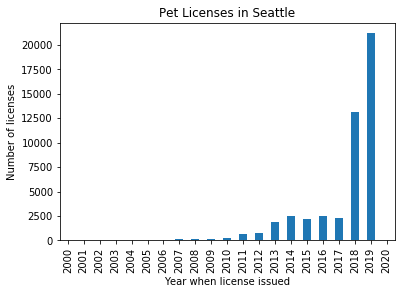

In [27]:
df_licenses['License Issue Date'].groupby(df_licenses['License Issue Date'].dt.year).count().plot(kind='bar')
plt.ylabel('Number of licenses')
plt.xlabel('Year when license issued')
plt.title('Pet Licenses in Seattle')

In [28]:
# Choose rows where license is issued > 2010-01-01
df_licenses = df_licenses[(df_licenses['License Issue Date'] >= '2010-01-01')].reset_index(drop=True)
df_licenses.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,2010-01-07,24408,Shia,Dog,"Retriever, Labrador",Border Collie,98109
1,2010-01-11,24567,Kia,Dog,American Eskimo,NaN,98177
2,2010-01-11,24142,Sable,Dog,"Terrier, American Pit Bull",Mix,98126
3,2010-01-11,24532,Belle,Dog,Shepherd,Mix,98115
4,2010-01-15,24575,Riley,Dog,"Retriever, Labrador",NaN,98118


In [29]:
# What species we have in dataframe?
pd.DataFrame(df_licenses.groupby('Species')['License Number'].nunique())

,License Number
Species,
Cat,15885
Dog,31342
Goat,36
Pig,3


In [30]:
# Ok, let's skip the pigs and goats and concentrate on cats and dogs
df_licenses = df_licenses.loc[df_licenses.Species.str.contains('Dog|Cat')]

In [31]:
# Choose the columns we need
df_licenses = df_licenses[['ZIP Code', 'License Issue Date', 'License Number', 'Species']].reset_index(drop=True)
df_licenses.head()

,ZIP Code,License Issue Date,License Number,Species
0,98109,2010-01-07,24408,Dog
1,98177,2010-01-11,24567,Dog
2,98126,2010-01-11,24142,Dog
3,98115,2010-01-11,24532,Dog
4,98118,2010-01-15,24575,Dog


In [32]:
# Unique zip codes in the dataframe
print('The number of unique zip codes: ', df_licenses['ZIP Code'].nunique())
df_licenses['ZIP Code'].unique().tolist()

The number of unique zip codes:  198


['98109',
 '98177',
 '98126',
 '98115',
 '98118',
 '98106',
 '98146',
 '98124',
 '98101',
 '98136',
 '98168',
 '98112',
 '98108',
 '98122',
 '98026',
 '98103',
 '98117',
 '98199',
 '98198',
 '98102',
 '98116',
 '98121',
 '98107',
 '98125',
 '98119',
 '98134',
 '98178',
 '98104',
 '98144',
 '98133',
 '98528',
 '98113',
 '97107',
 '98137',
 '98135',
 '98105',
 '98139',
 '98111',
 '98059',
 '98404',
 '98145',
 '98204',
 '98013',
 '98042',
 '98165',
 '98004',
 '98034',
 '98155',
 '98057',
 '98127',
 '98277',
 '98507',
 '4849',
 '91803',
 '97451',
 '96734',
 '9811',
 '98080',
 '98360',
 '98584',
 '98052',
 '98520',
 '98070',
 '98023',
 '98312',
 '98902',
 '98164',
 '98175',
 '98188',
 '83353',
 '98027',
 '98179',
 '98290',
 '98717',
 '98149',
 '98148',
 '99810',
 '98166',
 '98020',
 '98408',
 '98056',
 '98011',
 '98422',
 '98036',
 '98701',
 '98392',
 '98133-8525',
 '98498',
 '98329',
 '98592',
 '98174',
 '9812',
 '98114',
 '98199-3508',
 '94107',
 '80015',
 '98178-2442',
 '97702',
 '98596'

In [33]:
# Delete the extra numbers in zip codes - leave only the first five numbers of the zip code
df_licenses['ZIP Code'] = df_licenses['ZIP Code'].str.slice(start=0, stop=5)
print('The number of unique zip codes now: ', df_licenses['ZIP Code'].nunique())

The number of unique zip codes now:  166


In [34]:
# Number of licenses in each zip code area
df_licenses_g = pd.DataFrame(df_licenses.groupby('ZIP Code')['License Number'].nunique().sort_values(ascending=False).reset_index())
df_licenses_g.rename(columns = {'License Number':'Number of Licenses'}, inplace=True)
df_licenses_g.head()

,ZIP Code,Number of Licenses
0,98115,4134
1,98103,3874
2,98117,3472
3,98125,2617
4,98122,2357


In [35]:
df_licenses_g.shape

(166, 2)

#### Merge the DataFrames: Zip Codes, Neighborhoods, Coordinates and Pet Licenses

In [94]:
# Let's merge neighborhoods and coordinates to pet license data.

In [36]:
# Change the dtype of column zip codes to str
df_licenses_g['ZIP Code'] = df_licenses_g['ZIP Code'].astype('str')
df_seattle_neighborhoods['ZIP Code'] = df_seattle_neighborhoods['ZIP Code'].astype('str')
df_uszips_seattle['ZIP Code'] = df_uszips_seattle['ZIP Code'].astype('str')

C:\Users\U589514\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
# Merge neighborhoods to pet license data 
df_licenses_m =  pd.merge(pd.merge(df_licenses_g, df_seattle_neighborhoods, on='ZIP Code', how='left'
                                  ), df_uszips_seattle, on='ZIP Code', how='left')
df_licenses_m.head()

,ZIP Code,Number of Licenses,Seattle Neighborhood,Latitude,Longitude
0,98115,4134,Northeast,47.68500,-122.28216
1,98103,3874,Lake Union,47.67332,-122.34254
2,98117,3472,Ballard,47.68820,-122.38148
3,98125,2617,North,47.71636,-122.29815
4,98122,2357,Central,47.61151,-122.29180


In [38]:
# Take the rows where neighborhood is not NaN/null - they are not part of Seattle
df_licenses_m.dropna(subset = ['Seattle Neighborhood'], inplace=True)
df_licenses_m

,ZIP Code,Number of Licenses,Seattle Neighborhood,Latitude,Longitude
0,98115,4134,Northeast,47.68500,-122.28216
1,98103,3874,Lake Union,47.67332,-122.34254
2,98117,3472,Ballard,47.68820,-122.38148
3,98125,2617,North,47.71636,-122.29815
4,98122,2357,Central,47.61151,-122.29180
5,98118,2299,Southeast,47.54249,-122.26883
6,98107,2264,Ballard,47.66764,-122.37800
7,98116,2094,Southwest,47.57397,-122.39507
8,98199,1981,Queen Anne/Magnolia,47.65142,-122.40270
9,98105,1780,Northeast,47.66068,-122.28403


In [39]:
# Drop also the rows where coordinates are NaN
df_licenses_m.dropna(subset = ['Latitude'], inplace=True)
df_licenses_m

,ZIP Code,Number of Licenses,Seattle Neighborhood,Latitude,Longitude
0,98115,4134,Northeast,47.68500,-122.28216
1,98103,3874,Lake Union,47.67332,-122.34254
2,98117,3472,Ballard,47.68820,-122.38148
3,98125,2617,North,47.71636,-122.29815
4,98122,2357,Central,47.61151,-122.29180
5,98118,2299,Southeast,47.54249,-122.26883
6,98107,2264,Ballard,47.66764,-122.37800
7,98116,2094,Southwest,47.57397,-122.39507
8,98199,1981,Queen Anne/Magnolia,47.65142,-122.40270
9,98105,1780,Northeast,47.66068,-122.28403


In [40]:
# Number of licenses in each zip code area
df_licenses_n = pd.DataFrame(df_licenses_m.groupby('Seattle Neighborhood')['Number of Licenses'].
                             sum().sort_values(ascending=False).reset_index())
df_licenses_n

,Seattle Neighborhood,Number of Licenses
0,Northeast,5923
1,Ballard,5736
2,Queen Anne/Magnolia,5448
3,Southwest,4173
4,Southeast,4017
5,Lake Union,3874
6,Delridge,3503
7,Capitol Hill,3241
8,North,2617
9,Northwest,2402


In [41]:
df_licenses_n_index = df_licenses_n.set_index('Seattle Neighborhood')
df_licenses_n_index

,Number of Licenses
Seattle Neighborhood,
Northeast,5923
Ballard,5736
Queen Anne/Magnolia,5448
Southwest,4173
Southeast,4017
Lake Union,3874
Delridge,3503
Capitol Hill,3241
North,2617


In [42]:
# First get the latitude and longitude values of Seattle

address = 'Seattle, Washington'
geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


In [43]:
# Create map of pet licenses in Seattle neighborhoods using latitude and longitude values
map_pets = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, zipcode, licenses in zip(df_licenses_m['Latitude'], df_licenses_m['Longitude'], df_licenses_m['Seattle Neighborhood'], df_licenses_m['ZIP Code'], df_licenses_m['Number of Licenses']):
    label = '{}, {}, {}'.format(neighborhood, zipcode, licenses)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pets)  
    
map_pets

#### Create DataFrame: Seattle Neighborhoods and Population

In [44]:
# Let's use the uszips data again and choose the rows where city name is Seattle and rename the dataframe
df_seattle_pop = df_uszips_all.loc[df_uszips_all['city'] == 'Seattle']
df_seattle_pop.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
32319,98101,47.61129,-122.33454,Seattle,WA,Washington,True,NaN,12792,7613.3,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles
32320,98102,47.63632,-122.32213,Seattle,WA,Washington,True,NaN,25448,6228.4,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles
32321,98103,47.67332,-122.34254,Seattle,WA,Washington,True,NaN,51377,3815.7,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles
32322,98104,47.60169,-122.32849,Seattle,WA,Washington,True,NaN,14144,6533.8,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles
32323,98105,47.66068,-122.28403,Seattle,WA,Washington,True,NaN,48861,4108.7,53033,King,{'53033':100},King,53033,False,False,America/Los_Angeles


In [45]:
# Then take the columns we need and rename columns
df_seattle_pop = df_seattle_pop[['zip','population']].reset_index(drop=True)
df_seattle_pop.rename(columns = {'zip': 'ZIP Code', 'population':'Population'}, inplace=True)
df_seattle_pop.head()

,ZIP Code,Population
0,98101,12792
1,98102,25448
2,98103,51377
3,98104,14144
4,98105,48861


In [46]:
# Change the dtype of column zip codes to str
df_seattle_pop['ZIP Code'] = df_seattle_pop['ZIP Code'].astype('str')

In [47]:
# Let's merge zip codes, population and Seattle neighborhood and sort the values by population
df_seattle_pop_neigh = pd.merge(df_seattle_neighborhoods, df_seattle_pop, on='ZIP Code', how='left').sort_values(by='Population', ascending=False).reset_index(drop=True)
df_seattle_pop_neigh.head()

,ZIP Code,Seattle Neighborhood,Population
0,98115,Northeast,53431.0
1,98103,Lake Union,51377.0
2,98105,Northeast,48861.0
3,98118,Southeast,48436.0
4,98133,Northwest,47247.0


In [48]:
# Group by neighborhood to get population of each neighborhood
df_seattle_pop_neigh_g = pd.DataFrame(df_seattle_pop_neigh.groupby('Seattle Neighborhood')['Population'].sum()
                                     ).sort_values(by='Population', ascending=False).reset_index(drop=False)
df_seattle_pop_neigh_g

,Seattle Neighborhood,Population
0,Northeast,102343.0
1,Southeast,80281.0
2,Queen Anne/Magnolia,76818.0
3,Southwest,71077.0
4,Northwest,68866.0
5,Ballard,60831.0
6,Lake Union,51377.0
7,Capitol Hill,50874.0
8,Delridge,50500.0
9,Downtown,45231.0


In [49]:
# Drop the rows where neighborhood is not 'North' or 'South Urban' - they are not part of the city of Seattle
not_seattle = ['North', 'South Urban']
df_seattle_pop_neigh_g = df_seattle_pop_neigh_g[~df_seattle_pop_neigh_g['Seattle Neighborhood'].isin(not_seattle)]
df_seattle_pop_neigh_g

,Seattle Neighborhood,Population
0,Northeast,102343.0
1,Southeast,80281.0
2,Queen Anne/Magnolia,76818.0
3,Southwest,71077.0
4,Northwest,68866.0
5,Ballard,60831.0
6,Lake Union,51377.0
7,Capitol Hill,50874.0
8,Delridge,50500.0
9,Downtown,45231.0


In [50]:
# Let's merge number of licenses to the dataframe by neighborhood
df_seattle_pop_licenses = pd.merge(df_seattle_pop_neigh_g, df_licenses_n, on='Seattle Neighborhood', 
                                   how='left').sort_values(by='Population', ascending=False).reset_index(drop=True)
df_seattle_pop_licenses

,Seattle Neighborhood,Population,Number of Licenses
0,Northeast,102343.0,5923
1,Southeast,80281.0,4017
2,Queen Anne/Magnolia,76818.0,5448
3,Southwest,71077.0,4173
4,Northwest,68866.0,2402
5,Ballard,60831.0,5736
6,Lake Union,51377.0,3874
7,Capitol Hill,50874.0,3241
8,Delridge,50500.0,3503
9,Downtown,45231.0,2044


In [51]:
# How many pet licenses per person in each neighborhood
df_seattle_pop_licenses['Licenses per person'] = df_seattle_pop_licenses['Number of Licenses'
                                                                        ] / df_seattle_pop_licenses['Population']
# How many people per pet license in each neighborhood
df_seattle_pop_licenses['People per license'] = df_seattle_pop_licenses['Population'
                                                                       ] /df_seattle_pop_licenses['Number of Licenses']
df_seattle_pop_licenses

,Seattle Neighborhood,Population,Number of Licenses,Licenses per person,People per license
0,Northeast,102343.0,5923,0.057874,17.278913
1,Southeast,80281.0,4017,0.050037,19.985312
2,Queen Anne/Magnolia,76818.0,5448,0.070921,14.100220
3,Southwest,71077.0,4173,0.058711,17.032590
4,Northwest,68866.0,2402,0.034879,28.670275
5,Ballard,60831.0,5736,0.094294,10.605126
6,Lake Union,51377.0,3874,0.075403,13.262003
7,Capitol Hill,50874.0,3241,0.063706,15.697007
8,Delridge,50500.0,3503,0.069366,14.416215
9,Downtown,45231.0,2044,0.045190,22.128669


In [52]:
df_seattle_pop_licenses['Licenses per person']  = df_seattle_pop_licenses['Licenses per person'].round(2)
df_seattle_pop_licenses['People per license']  = df_seattle_pop_licenses['People per license'].round(2)
df_seattle_pop_licenses['Population']  = df_seattle_pop_licenses['Population'].astype(int)
df_seattle_pop_licenses['Number of Licenses']  = df_seattle_pop_licenses['Number of Licenses'].astype(int)
df_seattle_pop_licenses

,Seattle Neighborhood,Population,Number of Licenses,Licenses per person,People per license
0,Northeast,102343,5923,0.06,17.28
1,Southeast,80281,4017,0.05,19.99
2,Queen Anne/Magnolia,76818,5448,0.07,14.10
3,Southwest,71077,4173,0.06,17.03
4,Northwest,68866,2402,0.03,28.67
5,Ballard,60831,5736,0.09,10.61
6,Lake Union,51377,3874,0.08,13.26
7,Capitol Hill,50874,3241,0.06,15.70
8,Delridge,50500,3503,0.07,14.42
9,Downtown,45231,2044,0.05,22.13


In [53]:
seattle_index = df_seattle_pop_licenses.set_index('Seattle Neighborhood', inplace=True)
seattle_index

In [54]:
df_seattle_pop_licenses

,Population,Number of Licenses,Licenses per person,People per license
Seattle Neighborhood,,,,
Northeast,102343,5923,0.06,17.28
Southeast,80281,4017,0.05,19.99
Queen Anne/Magnolia,76818,5448,0.07,14.10
Southwest,71077,4173,0.06,17.03
Northwest,68866,2402,0.03,28.67
Ballard,60831,5736,0.09,10.61
Lake Union,51377,3874,0.08,13.26
Capitol Hill,50874,3241,0.06,15.70
Delridge,50500,3503,0.07,14.42


#### Segmenting and Analyzing the Seattle Neighborhoods

In [55]:
df_licenses_m.head()

,ZIP Code,Number of Licenses,Seattle Neighborhood,Latitude,Longitude
0,98115,4134,Northeast,47.68500,-122.28216
1,98103,3874,Lake Union,47.67332,-122.34254
2,98117,3472,Ballard,47.68820,-122.38148
3,98125,2617,North,47.71636,-122.29815
4,98122,2357,Central,47.61151,-122.29180


In [56]:
LIMIT = 500 # Limit of number of venues returned by Foursquare API

CLIENT_ID = foursquare_pwd.CLIENT_ID # your Foursquare ID
CLIENT_SECRET = foursquare_pwd.CLIENT_SECRET # your Foursquare Secret
VERSION = foursquare_pwd.VERSION # Foursquare API version

In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [58]:
seattle_venues = getNearbyVenues(names = df_licenses_m['Seattle Neighborhood'],
                                   latitudes = df_licenses_m['Latitude'],
                                   longitudes = df_licenses_m['Longitude']
                                  )

Northeast
Lake Union
Ballard
North 
Central
Southeast
Ballard
Southwest
Queen Anne/Magnolia
Northeast
Delridge
Queen Anne/Magnolia
Delridge
Queen Anne/Magnolia
Southeast
Capitol Hill
Northwest
Capitol Hill
Southwest
Duwamish
Downtown
Northwest
Downtown
Southwest
Downtown
Duwamish
Downtown
Northeast
Downtown


In [59]:
# Let's check the size of the resulting dataframe

print(seattle_venues.shape)
seattle_venues.head()

(2891, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Northeast,47.685,-122.28216,Grateful Bread Baking Company & Cafe,47.679496,-122.290504,Café
1,Northeast,47.685,-122.28216,PCC Community Markets,47.676020,-122.284820,Organic Grocery
2,Northeast,47.685,-122.28216,Top Pot Doughnuts,47.679193,-122.290544,Donut Shop
3,Northeast,47.685,-122.28216,Sand Point Country Club,47.689068,-122.269300,Golf Course
4,Northeast,47.685,-122.28216,Sunflour - Bryant Corner Cafe & Bakery,47.675873,-122.293287,Café


In [60]:
# Check how many venues were returned for each neighborhood
seattle_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ballard,200,200,200,200,200,200
Capitol Hill,200,200,200,200,200,200
Central,100,100,100,100,100,100
Delridge,200,200,200,200,200,200
Downtown,500,500,500,500,500,500
Duwamish,200,200,200,200,200,200
Lake Union,100,100,100,100,100,100
North,100,100,100,100,100,100
Northeast,300,300,300,300,300,300


In [61]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(
    seattle_venues['Venue Category'].unique())))

There are 206 uniques categories.


In [62]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['Neighborhood'] = seattle_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_onehot.head()

,Zoo Exhibit,Accessories Store,African Restaurant,Airport,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,BBQ Joint,Bakery,Bar,Baseball Field,Baseball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Boat or Ferry,Bookstore,Botanical Garden,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Campground,Canal,Canal Lock,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,High School,Historic Site,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Library,Lighthouse,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Noodle House,Organic Grocery,Outdoor Sculpture,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Roller Rink,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Plaza,Smoothie Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Northeast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Northeast,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [63]:
seattle_onehot.shape

(2891, 206)

In [64]:
# Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,African Restaurant,Airport,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,BBQ Joint,Bakery,Bar,Baseball Field,Baseball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Boat or Ferry,Bookstore,Botanical Garden,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Campground,Canal,Canal Lock,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,High School,Historic Site,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Library,Lighthouse,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Noodle House,Organic Grocery,Outdoor Sculpture,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Roller Rink,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Plaza,Smoothie Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Ballard,0.005,0.0,0.0,0.0,0.010,0.005,0.000,0.000,0.00,0.00,0.0,0.0,0.0,0.000,0.030,0.040,0.005,0.000,0.020,0.020,0.00,0.010,0.01,0.010,0.00,0.005,0.045,0.000,0.035,0.000,0.0,0.015,0.00,0.00,0.0,0.01,0.035,0.000,0.010,0.005,0.000,0.0,0.005,0.025,0.000,0.0,0.005,0.0,0.00,0.00,0.0,0.0,0.000,0.010,0.0,0.00,0.020,0.005,0.0,0.000,0.00,0.010,0.000,0.00,0.0,0.000,0.005,0.020,0.0,0.000,0.005,0.01,0.000,0.000,0.0,0.000,0.00,0.000,0.020,0.000,0.00,0.01,0.0,0.00,0.005,0.010,0.000,0.000,0.000,0.0,0.0,0.00,0.005,0.015,0.010,0.000,0.0,0.0,0.000,0.000,0.0,0.00,0.005,0.0,0.000,0.000,0.03,0.000,0.000,0.0,0.0,0.010,0.010,0.000,0.000,0.000,0.005,0.00,0.0,0.0,0.000,0.000,0.00,0.010,0.000,0.005,0.01,0.04,0.010,0.01,0.0,0.000,0.000,0.010,0.0,0.010,0.0,0.005,0.0,0.050,0.000,0.0,0.005,0.000,0.010,0.0,0.055,0.010,0.000,0.000,0.00,0.010,0.005,0.000,0.000,0.01,0.000,0.01,0.00,0.0,0.0,0.015,0.000,0.0,0.000,0.030,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.00,0.00,0.000,0.0,0.005,0.0,0.010,0.000,0.0,0.005,0.00,0.01,0.0,0.015,0.0,0.01,0.000,0.005,0.005,0.0,0.0,0.005,0.0,0.00,0.0,0.

In [65]:
# Let's confirm the new size
seattle_grouped.shape

(13, 206)

In [66]:
# Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in seattle_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ballard----
                  venue  freq
0           Pizza Place  0.06
1                  Park  0.05
2  Caribbean Restaurant  0.04
3          Burger Joint  0.04
4               Brewery  0.04


----Capitol Hill----
                venue  freq
0         Coffee Shop  0.10
1                Park  0.06
2       Grocery Store  0.04
3  Italian Restaurant  0.04
4      Sandwich Place  0.04


----Central----
                   venue  freq
0            Coffee Shop  0.12
1  Vietnamese Restaurant  0.06
2      French Restaurant  0.03
3           Cocktail Bar  0.03
4     Italian Restaurant  0.03


----Delridge----
           venue  freq
0    Coffee Shop  0.12
1        Brewery  0.06
2   Burger Joint  0.04
3    Pizza Place  0.04
4  Grocery Store  0.03


----Downtown----
               venue  freq
0        Coffee Shop  0.06
1             Bakery  0.05
2              Hotel  0.04
3  French Restaurant  0.03
4   Sushi Restaurant  0.03


----Duwamish----
                   venue  freq
0            Coffee S

In [67]:
# Let's put that into a pandas dataframe. 
# First, let's write a function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [68]:
# Now let's create the new dataframe and display the top 25 venues for each neighborhood
num_top_venues = 25

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,Ballard,Pizza Place,Park,Brewery,Bar,Mexican Restaurant,Caribbean Restaurant,Burger Joint,Seafood Restaurant,Bakery,Ice Cream Shop,Coffee Shop,Farmers Market,Dessert Shop,French Restaurant,Beach,Beer Bar,Thai Restaurant,Grocery Store,Sandwich Place,Café,Italian Restaurant,Gastropub,New American Restaurant,Museum,Gym
1,Capitol Hill,Coffee Shop,Park,Italian Restaurant,Sandwich Place,Grocery Store,Bakery,Cocktail Bar,Yoga Studio,Donut Shop,Sushi Restaurant,Taco Place,Scenic Lookout,Ice Cream Shop,Bookstore,Museum,Garden,Gym,Deli / Bodega,American Restaurant,Wine Bar,Japanese Restaurant,Indie Movie Theater,Juice Bar,Malay Restaurant,Karaoke Bar
2,Central,Coffee Shop,Vietnamese Restaurant,Italian Restaurant,French Restaurant,Scenic Lookout,Cocktail Bar,Bakery,Bookstore,Thai Restaurant,Beach,Indie Movie Theater,Sushi Restaurant,Taco Place,Yoga Studio,Brewery,Burger Joint,Japanese Restaurant,Mexican Restaurant,Sandwich Place,Grocery Store,Donut Shop,Park,Garden,Art Gallery,Ramen Restaurant
3,Delridge,Coffee Shop,Brewery,Burger Joint,Pizza Place,Beach,Grocery Store,Bakery,Lounge,Pub,Bar,Park,Scenic Lookout,Vietnamese Restaurant,Beer Store,Hawaiian Restaurant,Pet Store,Farmers Market,Diner,Fried Chicken Joint,Arts & Crafts Store,Cajun / Creole Restaurant,Campground,Food Truck,Sandwich Place,Dog Run
4,Downtown,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Yoga Studio,Donut Shop,Pet Store,Park,Brewery,Bookstore,Cheese Shop,Art Museum,Grocery Store,Performing Arts Venue,Gym / Fitness Center,Movie Theater,Scenic Lookout,Indie Movie Theater


In [69]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,Ballard,Pizza Place,Park,Brewery,Bar,Mexican Restaurant,Caribbean Restaurant,Burger Joint,Seafood Restaurant,Bakery,Ice Cream Shop,Coffee Shop,Farmers Market,Dessert Shop,French Restaurant,Beach,Beer Bar,Thai Restaurant,Grocery Store,Sandwich Place,Café,Italian Restaurant,Gastropub,New American Restaurant,Museum,Gym
1,Capitol Hill,Coffee Shop,Park,Italian Restaurant,Sandwich Place,Grocery Store,Bakery,Cocktail Bar,Yoga Studio,Donut Shop,Sushi Restaurant,Taco Place,Scenic Lookout,Ice Cream Shop,Bookstore,Museum,Garden,Gym,Deli / Bodega,American Restaurant,Wine Bar,Japanese Restaurant,Indie Movie Theater,Juice Bar,Malay Restaurant,Karaoke Bar
2,Central,Coffee Shop,Vietnamese Restaurant,Italian Restaurant,French Restaurant,Scenic Lookout,Cocktail Bar,Bakery,Bookstore,Thai Restaurant,Beach,Indie Movie Theater,Sushi Restaurant,Taco Place,Yoga Studio,Brewery,Burger Joint,Japanese Restaurant,Mexican Restaurant,Sandwich Place,Grocery Store,Donut Shop,Park,Garden,Art Gallery,Ramen Restaurant
3,Delridge,Coffee Shop,Brewery,Burger Joint,Pizza Place,Beach,Grocery Store,Bakery,Lounge,Pub,Bar,Park,Scenic Lookout,Vietnamese Restaurant,Beer Store,Hawaiian Restaurant,Pet Store,Farmers Market,Diner,Fried Chicken Joint,Arts & Crafts Store,Cajun / Creole Restaurant,Campground,Food Truck,Sandwich Place,Dog Run
4,Downtown,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Yoga Studio,Donut Shop,Pet Store,Park,Brewery,Bookstore,Cheese Shop,Art Museum,Grocery Store,Performing Arts Venue,Gym / Fitness Center,Movie Theater,Scenic Lookout,Indie Movie Theater
5,Duwamish,Coffee Shop,Brewery,Vietnamese Restaurant,Pub,Pizza Place,Bakery,Bar,Park,Mexican Restaurant,Mediterranean Restaurant,Bookstore,Hawaiian Restaurant,Food Truck,Italian Restaurant,Café,BBQ Joint,French Restaurant,Diner,Scenic Lookout,Burger Joint,Restaurant,Lounge,Seafood Restaurant,Cocktail Bar,Grocery Store
6,Lake Union,Park,Brewery,Pizza Place,Burger Joint,Coffee Shop,Ice Cream Shop,Bookstore,Bakery,Mediterranean Restaurant,Café,Caribbean Restaurant,Chinese Restaurant,Beer Bar,New American Restaurant,Bar,Deli / Bodega,Grocery Store,Japanese Restaurant,Farmers Market,American Restaurant,Dumpling Restaurant,Pie Shop,Greek Restaurant,Gym,Fried Chicken Joint
7,North,Coffee Shop,Pub,Park,Café,Thai Restaurant,Pizza Place,Mexican Restaurant,Bookstore,Bakery,Burger Joint,Indian Restaurant,Trail,Organic Grocery,Sandwich Place,Ethiopian Restaurant,Grocery Store,Donut Shop,Beer Bar,Dog Run,Food Truck,Vietnamese Restaurant,Korean Restaurant,Noodle House,Salon / Barbershop,American Restaurant
8,Northeast,Park,Coffee Shop,Grocery Store,Café,Bookstore,Italian Restaurant,American Restaurant,Burger Joint,Brewery,Thai Restaurant,Trail,Pizza Place,Ice Cream Shop,Bubble Tea Shop,Vegetarian / Vegan Restaurant,Sushi Restaurant,New American Restaurant,Organic Grocery,Mediterranean Restaurant,Pub,Dog Run,Seafood Restaurant,Bar,Farmers Market,Chocolate Shop
9,Northwest,Coffee Shop,Thai Restaurant,Park,American Restaurant,Grocery Store,Pizza Place,Mexican Restaurant,Korean Restaurant,Gym / Fitness Center,Food Truck,Vietnamese Restaurant,Burger Joint,Bakery,Playground,Latin American Restaurant,Sandwich Place,Chinese Restaurant,Bar,Pub,Beer Bar,Café,Garden Center,Athletics & Sports,Pharmacy,Indian Restaurant


In [70]:
df_licenses_m.rename(columns = {'Seattle Neighborhood':'Neighborhood'}, inplace=True)
df_licenses_m.head()

,ZIP Code,Number of Licenses,Neighborhood,Latitude,Longitude
0,98115,4134,Northeast,47.68500,-122.28216
1,98103,3874,Lake Union,47.67332,-122.34254
2,98117,3472,Ballard,47.68820,-122.38148
3,98125,2617,North,47.71636,-122.29815
4,98122,2357,Central,47.61151,-122.29180


In [71]:
# set number of clusters
kclusters = 5

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 0, 1, 0, 4, 3, 2, 3, 2])

In [72]:
# Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge dataframes to add latitude/longitude for each neighborhood
seattle_m = df_licenses_m.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_m.head() # check the last columns!

,ZIP Code,Number of Licenses,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,98115,4134,Northeast,47.68500,-122.28216,3,Park,Coffee Shop,Grocery Store,Café,Bookstore,Italian Restaurant,American Restaurant,Burger Joint,Brewery,Thai Restaurant,Trail,Pizza Place,Ice Cream Shop,Bubble Tea Shop,Vegetarian / Vegan Restaurant,Sushi Restaurant,New American Restaurant,Organic Grocery,Mediterranean Restaurant,Pub,Dog Run,Seafood Restaurant,Bar,Farmers Market,Chocolate Shop
1,98103,3874,Lake Union,47.67332,-122.34254,3,Park,Brewery,Pizza Place,Burger Joint,Coffee Shop,Ice Cream Shop,Bookstore,Bakery,Mediterranean Restaurant,Café,Caribbean Restaurant,Chinese Restaurant,Beer Bar,New American Restaurant,Bar,Deli / Bodega,Grocery Store,Japanese Restaurant,Farmers Market,American Restaurant,Dumpling Restaurant,Pie Shop,Greek Restaurant,Gym,Fried Chicken Joint
2,98117,3472,Ballard,47.68820,-122.38148,3,Pizza Place,Park,Brewery,Bar,Mexican Restaurant,Caribbean Restaurant,Burger Joint,Seafood Restaurant,Bakery,Ice Cream Shop,Coffee Shop,Farmers Market,Dessert Shop,French Restaurant,Beach,Beer Bar,Thai Restaurant,Grocery Store,Sandwich Place,Café,Italian Restaurant,Gastropub,New American Restaurant,Museum,Gym
3,98125,2617,North,47.71636,-122.29815,2,Coffee Shop,Pub,Park,Café,Thai Restaurant,Pizza Place,Mexican Restaurant,Bookstore,Bakery,Burger Joint,Indian Restaurant,Trail,Organic Grocery,Sandwich Place,Ethiopian Restaurant,Grocery Store,Donut Shop,Beer Bar,Dog Run,Food Truck,Vietnamese Restaurant,Korean Restaurant,Noodle House,Salon / Barbershop,American Restaurant
4,98122,2357,Central,47.61151,-122.29180,0,Coffee Shop,Vietnamese Restaurant,Italian Restaurant,French Restaurant,Scenic Lookout,Cocktail Bar,Bakery,Bookstore,Thai Restaurant,Beach,Indie Movie Theater,Sushi Restaurant,Taco Place,Yoga Studio,Brewery,Burger Joint,Japanese Restaurant,Mexican Restaurant,Sandwich Place,Grocery Store,Donut Shop,Park,Garden,Art Gallery,Ramen Restaurant


In [73]:
# There are NaN values in column Cluster Labels - let's take only the rows where Cluster label is not NaN
seattle_m = seattle_m[seattle_m['Cluster Labels'].notna()]
seattle_m.head()

,ZIP Code,Number of Licenses,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,98115,4134,Northeast,47.68500,-122.28216,3,Park,Coffee Shop,Grocery Store,Café,Bookstore,Italian Restaurant,American Restaurant,Burger Joint,Brewery,Thai Restaurant,Trail,Pizza Place,Ice Cream Shop,Bubble Tea Shop,Vegetarian / Vegan Restaurant,Sushi Restaurant,New American Restaurant,Organic Grocery,Mediterranean Restaurant,Pub,Dog Run,Seafood Restaurant,Bar,Farmers Market,Chocolate Shop
1,98103,3874,Lake Union,47.67332,-122.34254,3,Park,Brewery,Pizza Place,Burger Joint,Coffee Shop,Ice Cream Shop,Bookstore,Bakery,Mediterranean Restaurant,Café,Caribbean Restaurant,Chinese Restaurant,Beer Bar,New American Restaurant,Bar,Deli / Bodega,Grocery Store,Japanese Restaurant,Farmers Market,American Restaurant,Dumpling Restaurant,Pie Shop,Greek Restaurant,Gym,Fried Chicken Joint
2,98117,3472,Ballard,47.68820,-122.38148,3,Pizza Place,Park,Brewery,Bar,Mexican Restaurant,Caribbean Restaurant,Burger Joint,Seafood Restaurant,Bakery,Ice Cream Shop,Coffee Shop,Farmers Market,Dessert Shop,French Restaurant,Beach,Beer Bar,Thai Restaurant,Grocery Store,Sandwich Place,Café,Italian Restaurant,Gastropub,New American Restaurant,Museum,Gym
3,98125,2617,North,47.71636,-122.29815,2,Coffee Shop,Pub,Park,Café,Thai Restaurant,Pizza Place,Mexican Restaurant,Bookstore,Bakery,Burger Joint,Indian Restaurant,Trail,Organic Grocery,Sandwich Place,Ethiopian Restaurant,Grocery Store,Donut Shop,Beer Bar,Dog Run,Food Truck,Vietnamese Restaurant,Korean Restaurant,Noodle House,Salon / Barbershop,American Restaurant
4,98122,2357,Central,47.61151,-122.29180,0,Coffee Shop,Vietnamese Restaurant,Italian Restaurant,French Restaurant,Scenic Lookout,Cocktail Bar,Bakery,Bookstore,Thai Restaurant,Beach,Indie Movie Theater,Sushi Restaurant,Taco Place,Yoga Studio,Brewery,Burger Joint,Japanese Restaurant,Mexican Restaurant,Sandwich Place,Grocery Store,Donut Shop,Park,Garden,Art Gallery,Ramen Restaurant


In [74]:
# Lets change the column 'Cluster Labels' to integer
seattle_m['Cluster Labels'] = seattle_m['Cluster Labels'].astype('int')

In [111]:
# Finally, let's visualize the resulting clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_m['Latitude'], seattle_m['Longitude'], seattle_m['Neighborhood'], seattle_m['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [107]:
# Dataframe of top10 categories
neighborhoods_top10 = neighborhoods_venues_sorted[['Neighborhood',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']].set_index('Neighborhood')
neighborhoods_top10

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,
Ballard,Pizza Place,Park,Brewery,Bar,Mexican Restaurant,Caribbean Restaurant,Burger Joint,Seafood Restaurant,Bakery,Ice Cream Shop
Capitol Hill,Coffee Shop,Park,Italian Restaurant,Sandwich Place,Grocery Store,Bakery,Cocktail Bar,Yoga Studio,Donut Shop,Sushi Restaurant
Central,Coffee Shop,Vietnamese Restaurant,Italian Restaurant,French Restaurant,Scenic Lookout,Cocktail Bar,Bakery,Bookstore,Thai Restaurant,Beach
Delridge,Coffee Shop,Brewery,Burger Joint,Pizza Place,Beach,Grocery Store,Bakery,Lounge,Pub,Bar
Downtown,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant
Duwamish,Coffee Shop,Brewery,Vietnamese Restaurant,Pub,Pizza Place,Bakery,Bar,Park,Mexican Restaurant,Mediterranean Restaurant
Lake Union,Park,Brewery,Pizza Place,Burger Joint,Coffee Shop,Ice Cream Shop,Bookstore,Bakery,Mediterranean Restaurant,Café
North,Coffee Shop,Pub,Park,Café,Thai Restaurant,Pizza Place,Mexican Restaurant,Bookstore,Bakery,Burger Joint
Northeast,Park,Coffee Shop,Grocery Store,Café,Bookstore,Italian Restaurant,American Restaurant,Burger Joint,Brewery,Thai Restaurant


In [ ]:
log_work_cols = jira_data.columns[jira_data.columns.str.contains('Log Work')]
df_worklog = jira_data

####  Examine the Clusters

In [76]:
# Cluster 0 - Red
seattle_m.loc[seattle_m['Cluster Labels'] == 0, seattle_m.columns[[2] + list(range(5, seattle_m.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
4,Central,0,Coffee Shop,Vietnamese Restaurant,Italian Restaurant,French Restaurant,Scenic Lookout,Cocktail Bar,Bakery,Bookstore,Thai Restaurant,Beach,Indie Movie Theater,Sushi Restaurant,Taco Place,Yoga Studio,Brewery,Burger Joint,Japanese Restaurant,Mexican Restaurant,Sandwich Place,Grocery Store,Donut Shop,Park,Garden,Art Gallery,Ramen Restaurant
15,Capitol Hill,0,Coffee Shop,Park,Italian Restaurant,Sandwich Place,Grocery Store,Bakery,Cocktail Bar,Yoga Studio,Donut Shop,Sushi Restaurant,Taco Place,Scenic Lookout,Ice Cream Shop,Bookstore,Museum,Garden,Gym,Deli / Bodega,American Restaurant,Wine Bar,Japanese Restaurant,Indie Movie Theater,Juice Bar,Malay Restaurant,Karaoke Bar
17,Capitol Hill,0,Coffee Shop,Park,Italian Restaurant,Sandwich Place,Grocery Store,Bakery,Cocktail Bar,Yoga Studio,Donut Shop,Sushi Restaurant,Taco Place,Scenic Lookout,Ice Cream Shop,Bookstore,Museum,Garden,Gym,Deli / Bodega,American Restaurant,Wine Bar,Japanese Restaurant,Indie Movie Theater,Juice Bar,Malay Restaurant,Karaoke Bar
20,Downtown,0,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Yoga Studio,Donut Shop,Pet Store,Park,Brewery,Bookstore,Cheese Shop,Art Museum,Grocery Store,Performing Arts Venue,Gym / Fitness Center,Movie Theater,Scenic Lookout,Indie Movie Theater
22,Downtown,0,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Yoga Studio,Donut Shop,Pet Store,Park,Brewery,Bookstore,Cheese Shop,Art Museum,Grocery Store,Performing Arts Venue,Gym / Fitness Center,Movie Theater,Scenic Lookout,Indie Movie Theater
24,Downtown,0,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Yoga Studio,Donut Shop,Pet Store,Park,Brewery,Bookstore,Cheese Shop,Art Museum,Grocery Store,Performing Arts Venue,Gym / Fitness Center,Movie Theater,Scenic Lookout,Indie Movie Theater
33,Downtown,0,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Yoga Studio,Donut Shop,Pet Store,Park,Brewery,Bookstore,Cheese Shop,Art Museum,Grocery Store,Performing Arts Venue,Gym / Fitness Center,Movie Theater,Scenic Lookout,Indie Movie Theater
140,Downtown,0,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Yoga Studio,Donut Shop,Pet Store,Park,Brewery,Bookstore,Cheese Shop,Art Museum,Grocery Store,Performing Arts Venue,Gym / Fitness Center,Movie Theater,Scenic Lookout,Indie Movie Theater


In [77]:
# Cluster 1 - Purple
seattle_m.loc[seattle_m['Cluster Labels'] == 1, seattle_m.columns[[2] + list(range(5, seattle_m.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
7,Southwest,1,Coffee Shop,Pizza Place,Park,Burger Joint,Grocery Store,Beach,Bakery,Scenic Lookout,Brewery,Pub,Pet Store,Food Truck,Boat or Ferry,Beer Store,Vietnamese Restaurant,Lounge,Diner,Italian Restaurant,Bar,Fried Chicken Joint,Breakfast Spot,Sports Bar,Fish & Chips Shop,Playground,Mexican Restaurant
10,Delridge,1,Coffee Shop,Brewery,Burger Joint,Pizza Place,Beach,Grocery Store,Bakery,Lounge,Pub,Bar,Park,Scenic Lookout,Vietnamese Restaurant,Beer Store,Hawaiian Restaurant,Pet Store,Farmers Market,Diner,Fried Chicken Joint,Arts & Crafts Store,Cajun / Creole Restaurant,Campground,Food Truck,Sandwich Place,Dog Run
12,Delridge,1,Coffee Shop,Brewery,Burger Joint,Pizza Place,Beach,Grocery Store,Bakery,Lounge,Pub,Bar,Park,Scenic Lookout,Vietnamese Restaurant,Beer Store,Hawaiian Restaurant,Pet Store,Farmers Market,Diner,Fried Chicken Joint,Arts & Crafts Store,Cajun / Creole Restaurant,Campground,Food Truck,Sandwich Place,Dog Run
18,Southwest,1,Coffee Shop,Pizza Place,Park,Burger Joint,Grocery Store,Beach,Bakery,Scenic Lookout,Brewery,Pub,Pet Store,Food Truck,Boat or Ferry,Beer Store,Vietnamese Restaurant,Lounge,Diner,Italian Restaurant,Bar,Fried Chicken Joint,Breakfast Spot,Sports Bar,Fish & Chips Shop,Playground,Mexican Restaurant
23,Southwest,1,Coffee Shop,Pizza Place,Park,Burger Joint,Grocery Store,Beach,Bakery,Scenic Lookout,Brewery,Pub,Pet Store,Food Truck,Boat or Ferry,Beer Store,Vietnamese Restaurant,Lounge,Diner,Italian Restaurant,Bar,Fried Chicken Joint,Breakfast Spot,Sports Bar,Fish & Chips Shop,Playground,Mexican Restaurant


In [78]:
# Cluster 2 - Blue
seattle_m.loc[seattle_m['Cluster Labels'] == 2, seattle_m.columns[[2] + list(range(5, seattle_m.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
3,North,2,Coffee Shop,Pub,Park,Café,Thai Restaurant,Pizza Place,Mexican Restaurant,Bookstore,Bakery,Burger Joint,Indian Restaurant,Trail,Organic Grocery,Sandwich Place,Ethiopian Restaurant,Grocery Store,Donut Shop,Beer Bar,Dog Run,Food Truck,Vietnamese Restaurant,Korean Restaurant,Noodle House,Salon / Barbershop,American Restaurant
16,Northwest,2,Coffee Shop,Thai Restaurant,Park,American Restaurant,Grocery Store,Pizza Place,Mexican Restaurant,Korean Restaurant,Gym / Fitness Center,Food Truck,Vietnamese Restaurant,Burger Joint,Bakery,Playground,Latin American Restaurant,Sandwich Place,Chinese Restaurant,Bar,Pub,Beer Bar,Café,Garden Center,Athletics & Sports,Pharmacy,Indian Restaurant
21,Northwest,2,Coffee Shop,Thai Restaurant,Park,American Restaurant,Grocery Store,Pizza Place,Mexican Restaurant,Korean Restaurant,Gym / Fitness Center,Food Truck,Vietnamese Restaurant,Burger Joint,Bakery,Playground,Latin American Restaurant,Sandwich Place,Chinese Restaurant,Bar,Pub,Beer Bar,Café,Garden Center,Athletics & Sports,Pharmacy,Indian Restaurant


In [79]:
# Cluster 3 - Green
seattle_m.loc[seattle_m['Cluster Labels'] == 3, seattle_m.columns[[2] + list(range(5, seattle_m.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,Northeast,3,Park,Coffee Shop,Grocery Store,Café,Bookstore,Italian Restaurant,American Restaurant,Burger Joint,Brewery,Thai Restaurant,Trail,Pizza Place,Ice Cream Shop,Bubble Tea Shop,Vegetarian / Vegan Restaurant,Sushi Restaurant,New American Restaurant,Organic Grocery,Mediterranean Restaurant,Pub,Dog Run,Seafood Restaurant,Bar,Farmers Market,Chocolate Shop
1,Lake Union,3,Park,Brewery,Pizza Place,Burger Joint,Coffee Shop,Ice Cream Shop,Bookstore,Bakery,Mediterranean Restaurant,Café,Caribbean Restaurant,Chinese Restaurant,Beer Bar,New American Restaurant,Bar,Deli / Bodega,Grocery Store,Japanese Restaurant,Farmers Market,American Restaurant,Dumpling Restaurant,Pie Shop,Greek Restaurant,Gym,Fried Chicken Joint
2,Ballard,3,Pizza Place,Park,Brewery,Bar,Mexican Restaurant,Caribbean Restaurant,Burger Joint,Seafood Restaurant,Bakery,Ice Cream Shop,Coffee Shop,Farmers Market,Dessert Shop,French Restaurant,Beach,Beer Bar,Thai Restaurant,Grocery Store,Sandwich Place,Café,Italian Restaurant,Gastropub,New American Restaurant,Museum,Gym
6,Ballard,3,Pizza Place,Park,Brewery,Bar,Mexican Restaurant,Caribbean Restaurant,Burger Joint,Seafood Restaurant,Bakery,Ice Cream Shop,Coffee Shop,Farmers Market,Dessert Shop,French Restaurant,Beach,Beer Bar,Thai Restaurant,Grocery Store,Sandwich Place,Café,Italian Restaurant,Gastropub,New American Restaurant,Museum,Gym
8,Queen Anne/Magnolia,3,Park,Bakery,Brewery,Coffee Shop,Seafood Restaurant,Bar,Grocery Store,Scenic Lookout,Sandwich Place,Museum,Pizza Place,Farmers Market,Mexican Restaurant,Ice Cream Shop,Taco Place,Japanese Restaurant,Cocktail Bar,Sculpture Garden,Yoga Studio,Trail,Playground,Movie Theater,Italian Restaurant,Donut Shop,Sushi Restaurant
9,Northeast,3,Park,Coffee Shop,Grocery Store,Café,Bookstore,Italian Restaurant,American Restaurant,Burger Joint,Brewery,Thai Restaurant,Trail,Pizza Place,Ice Cream Shop,Bubble Tea Shop,Vegetarian / Vegan Restaurant,Sushi Restaurant,New American Restaurant,Organic Grocery,Mediterranean Restaurant,Pub,Dog Run,Seafood Restaurant,Bar,Farmers Market,Chocolate Shop
11,Queen Anne/Magnolia,3,Park,Bakery,Brewery,Coffee Shop,Seafood Restaurant,Bar,Grocery Store,Scenic Lookout,Sandwich Place,Museum,Pizza Place,Farmers Market,Mexican Restaurant,Ice Cream Shop,Taco Place,Japanese Restaurant,Cocktail Bar,Sculpture Garden,Yoga Studio,Trail,Playground,Movie Theater,Italian Restaurant,Donut Shop,Sushi Restaurant
13,Queen Anne/Magnolia,3,Park,Bakery,Brewery,Coffee Shop,Seafood Restaurant,Bar,Grocery Store,Scenic Lookout,Sandwich Place,Museum,Pizza Place,Farmers Market,Mexican Restaurant,Ice Cream Shop,Taco Place,Japanese Restaurant,Cocktail Bar,Sculpture Garden,Yoga Studio,Trail,Playground,Movie Theater,Italian Restaurant,Donut Shop,Sushi Restaurant
36,Northeast,3,Park,Coffee Shop,Grocery Store,Café,Bookstore,Italian Restaurant,American Restaurant,Burger Joint,Brewery,Thai Restaurant,Trail,Pizza Place,Ice Cream Shop,Bubble Tea Shop,Vegetarian / Vegan Restaurant,Sushi Restaurant,New American Restaurant,Organic Grocery,Mediterranean Restaurant,Pub,Dog Run,Seafood Restaurant,Bar,Farmers Market,Chocolate Shop


In [80]:
# Cluster 4 - Orange
seattle_m.loc[seattle_m['Cluster Labels'] == 4, seattle_m.columns[[2] + list(range(5, seattle_m.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
5,Southeast,4,Coffee Shop,Pizza Place,Brewery,Park,Vietnamese Restaurant,Bakery,Pub,Bar,Mediterranean Restaurant,Italian Restaurant,Café,Indie Movie Theater,Bookstore,Gastropub,Ethiopian Restaurant,Caribbean Restaurant,Diner,Fried Chicken Joint,Seafood Restaurant,Burger Joint,Music Venue,Museum,Science Museum,Marijuana Dispensary,Mexican Restaurant
14,Southeast,4,Coffee Shop,Pizza Place,Brewery,Park,Vietnamese Restaurant,Bakery,Pub,Bar,Mediterranean Restaurant,Italian Restaurant,Café,Indie Movie Theater,Bookstore,Gastropub,Ethiopian Restaurant,Caribbean Restaurant,Diner,Fried Chicken Joint,Seafood Restaurant,Burger Joint,Music Venue,Museum,Science Museum,Marijuana Dispensary,Mexican Restaurant
19,Duwamish,4,Coffee Shop,Brewery,Vietnamese Restaurant,Pub,Pizza Place,Bakery,Bar,Park,Mexican Restaurant,Mediterranean Restaurant,Bookstore,Hawaiian Restaurant,Food Truck,Italian Restaurant,Café,BBQ Joint,French Restaurant,Diner,Scenic Lookout,Burger Joint,Restaurant,Lounge,Seafood Restaurant,Cocktail Bar,Grocery Store
27,Duwamish,4,Coffee Shop,Brewery,Vietnamese Restaurant,Pub,Pizza Place,Bakery,Bar,Park,Mexican Restaurant,Mediterranean Restaurant,Bookstore,Hawaiian Restaurant,Food Truck,Italian Restaurant,Café,BBQ Joint,French Restaurant,Diner,Scenic Lookout,Burger Joint,Restaurant,Lounge,Seafood Restaurant,Cocktail Bar,Grocery Store


#### Other Pet Stores and Venues

In [81]:
# Other pet stores
pet_stores = seattle_venues.loc[seattle_venues['Venue Category'] ==  'Pet Store']
pet_stores

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
60,Northeast,47.68500,-122.28216,Mud Bay,47.662278,-122.300483,Pet Store
227,Ballard,47.68820,-122.38148,Mud Bay,47.691635,-122.357623,Pet Store
458,Central,47.61151,-122.29180,Mud Bay,47.614547,-122.320599,Pet Store
760,Southwest,47.57397,-122.39507,Pet Elements,47.544600,-122.387438,Pet Store
1059,Delridge,47.54349,-122.35434,Next To Nature,47.561585,-122.386847,Pet Store
1077,Delridge,47.54349,-122.35434,Pet Elements,47.544600,-122.387438,Pet Store
1162,Queen Anne/Magnolia,47.63159,-122.34417,Mud Bay,47.612213,-122.344799,Pet Store
1214,Delridge,47.54768,-122.37442,Pet Elements,47.544600,-122.387438,Pet Store
1489,Southeast,47.58596,-122.29237,Mud Bay,47.614547,-122.320599,Pet Store
1574,Capitol Hill,47.63394,-122.28885,Mud Bay,47.614547,-122.320599,Pet Store


In [82]:
pet_stores_g = pd.DataFrame(pet_stores.groupby('Neighborhood')['Venue'].nunique())
pet_stores_g.rename(columns = {'Venue':'Pet Stores'}, inplace=True)
pet_stores_g

,Pet Stores
Neighborhood,
Ballard,1
Capitol Hill,1
Central,1
Delridge,2
Downtown,1
Duwamish,1
Northeast,2
Queen Anne/Magnolia,1
Southeast,1


In [83]:
# Other pet related business?
pet_venues_list = ['Pet Caf', 'Dog Run', 'Animal Shelter', 'Veterinarian', 'Pet Service']
pet_venues = seattle_venues[seattle_venues['Venue Category'].str.contains('|'.join(pet_venues_list))]
pet_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
17,Northeast,47.68500,-122.28216,Magnuson Park Off-Leash Dog Park,47.686004,-122.254264,Dog Run
26,Northeast,47.68500,-122.28216,Magnuson Small Dog Area,47.682112,-122.256849,Dog Run
304,North,47.71636,-122.29815,Dogwood Indoor Dog Park,47.721127,-122.291762,Dog Run
317,North,47.71636,-122.29815,Great Dog,47.711213,-122.317965,Pet Service
398,North,47.71636,-122.29815,Magnuson Park Off-Leash Dog Park,47.686004,-122.254264,Dog Run
982,Northeast,47.66068,-122.28403,Magnuson Park Off-Leash Dog Park,47.686004,-122.254264,Dog Run
983,Northeast,47.66068,-122.28403,Magnuson Small Dog Area,47.682112,-122.256849,Dog Run
996,Delridge,47.54349,-122.35434,Westcrest Park,47.523845,-122.341540,Dog Run
1228,Delridge,47.54768,-122.37442,Westcrest Park,47.523845,-122.341540,Dog Run
1640,Northwest,47.73995,-122.34421,Dogwood Indoor Dog Park,47.721127,-122.291762,Dog Run


In [84]:
pet_venues_g = pd.DataFrame(pet_venues.groupby('Neighborhood')['Venue'].nunique())
pet_venues_g.rename(columns = {'Venue':'Other Pet Venues'}, inplace=True)
pet_venues_g

,Other Pet Venues
Neighborhood,
Delridge,1
Duwamish,1
North,3
Northeast,2
Northwest,1
Southwest,1


In [85]:
pet_venues_categories = pet_venues.groupby('Neighborhood').agg({'Venue Category': ', '.join})
pet_venues_categories.rename(columns = {'Venue Category':'Other Venues Categories'}, inplace=True)
pet_venues_categories

,Other Venues Categories
Neighborhood,
Delridge,"Dog Run, Dog Run"
Duwamish,Dog Run
North,"Dog Run, Pet Service, Dog Run"
Northeast,"Dog Run, Dog Run, Dog Run, Dog Run"
Northwest,Dog Run
Southwest,"Dog Run, Dog Run"


In [86]:
# What about parks?
parks = seattle_venues.loc[seattle_venues['Venue Category'] ==  'Park']
parks

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Northeast,47.68500,-122.28216,Warren G. Magnuson Park,47.680999,-122.258483,Park
6,Northeast,47.68500,-122.28216,View Ridge Area,47.679516,-122.271654,Park
9,Northeast,47.68500,-122.28216,Matthews Beach Park,47.696552,-122.273256,Park
13,Northeast,47.68500,-122.28216,View Ridge Playfield,47.679832,-122.280516,Park
24,Northeast,47.68500,-122.28216,Ravenna Park,47.670821,-122.304010,Park
25,Northeast,47.68500,-122.28216,Maple Leaf Park,47.690113,-122.316442,Park
65,Northeast,47.68500,-122.28216,Green Lake Park,47.680449,-122.332620,Park
93,Northeast,47.68500,-122.28216,Cowen Park,47.672085,-122.314777,Park
97,Northeast,47.68500,-122.28216,Laurelhurst Playfield,47.659689,-122.277802,Park
100,Lake Union,47.67332,-122.34254,Woodland Park,47.671945,-122.349269,Park


In [87]:
parks_g = pd.DataFrame(parks.groupby('Neighborhood')['Venue'].nunique())
parks_g.rename(columns = {'Venue':'Parks'}, inplace=True)
parks_g

,Parks
Neighborhood,
Ballard,7
Capitol Hill,6
Central,2
Delridge,3
Downtown,5
Duwamish,4
Lake Union,7
North,5
Northeast,15


In [88]:
# Merge neighborhoods to pet license data 
df_licenses_m =  pd.merge(pd.merge(df_licenses_g, df_seattle_neighborhoods, on='ZIP Code', how='left'
                                  ), df_uszips_seattle, on='ZIP Code', how='left')
df_licenses_m.head()

,ZIP Code,Number of Licenses,Seattle Neighborhood,Latitude,Longitude
0,98115,4134,Northeast,47.68500,-122.28216
1,98103,3874,Lake Union,47.67332,-122.34254
2,98117,3472,Ballard,47.68820,-122.38148
3,98125,2617,North,47.71636,-122.29815
4,98122,2357,Central,47.61151,-122.29180


In [89]:
# Merge the dataframes
df_seattle_all = df_seattle_pop_licenses.reset_index()
df_seattle_all = df_seattle_all.rename(columns={'Seattle Neighborhood':'Neighborhood'})
df_seattle_all = pd.merge(pd.merge(pd.merge(df_seattle_all, pet_stores_g, on='Neighborhood', how='left'), 
        parks_g, on='Neighborhood', how='left'), pet_venues_g, on='Neighborhood', how='left')
df_seattle_all.fillna('-', inplace=True)
df_seattle_all

,Neighborhood,Population,Number of Licenses,Licenses per person,People per license,Pet Stores,Parks,Other Pet Venues
0,Northeast,102343,5923,0.06,17.28,2,15,2
1,Southeast,80281,4017,0.05,19.99,1,6,-
2,Queen Anne/Magnolia,76818,5448,0.07,14.10,1,13,-
3,Southwest,71077,4173,0.06,17.03,4,9,1
4,Northwest,68866,2402,0.03,28.67,-,5,1
5,Ballard,60831,5736,0.09,10.61,1,7,-
6,Lake Union,51377,3874,0.08,13.26,-,7,-
7,Capitol Hill,50874,3241,0.06,15.70,1,6,-
8,Delridge,50500,3503,0.07,14.42,2,3,1
9,Downtown,45231,2044,0.05,22.13,1,5,-


In [90]:
df_seattle_pet_venues = df_seattle_all[['Neighborhood', 'Pet Stores', 'Parks', 'Other Pet Venues']]
df_seattle_pet_venues.set_index('Neighborhood', inplace=True)
df_seattle_pet_venues

,Pet Stores,Parks,Other Pet Venues
Neighborhood,,,
Northeast,2,15,2
Southeast,1,6,-
Queen Anne/Magnolia,1,13,-
Southwest,4,9,1
Northwest,-,5,1
Ballard,1,7,-
Lake Union,-,7,-
Capitol Hill,1,6,-
Delridge,2,3,1


-----

## 4. Results

The goal in this analysis was to find the best place for a new pet store in Seattle. Now let’s see what kind of results we got.

#### Seattle neighborhood with most pet licenses and population

Northeast is the biggest neighborhood in population and has the most licenses in Seattle neighborhoods. But when we compare the neighborhood in how many licenses per person or people per license they have, Ballard has relatively most pet owners in Seattle.

In [99]:
df_seattle_pop_licenses

,Population,Number of Licenses,Licenses per person,People per license
Seattle Neighborhood,,,,
Northeast,102343,5923,0.06,17.28
Southeast,80281,4017,0.05,19.99
Queen Anne/Magnolia,76818,5448,0.07,14.10
Southwest,71077,4173,0.06,17.03
Northwest,68866,2402,0.03,28.67
Ballard,60831,5736,0.09,10.61
Lake Union,51377,3874,0.08,13.26
Capitol Hill,50874,3241,0.06,15.70
Delridge,50500,3503,0.07,14.42


#### The most popular venues in Seattle neighborhoods

I listed the most popular venues in each neighborhood. It appeared that coffee shops are the 1st most common venue categories several neighborhoods. In top 10 there are lots of restaurants, pizza places and bars. Would the pet owners drop by to a pet store when going to café or restaurant? Surprisingly, there are also many parks among the popular venues. 

In [108]:
neighborhoods_top10

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,
Ballard,Pizza Place,Park,Brewery,Bar,Mexican Restaurant,Caribbean Restaurant,Burger Joint,Seafood Restaurant,Bakery,Ice Cream Shop
Capitol Hill,Coffee Shop,Park,Italian Restaurant,Sandwich Place,Grocery Store,Bakery,Cocktail Bar,Yoga Studio,Donut Shop,Sushi Restaurant
Central,Coffee Shop,Vietnamese Restaurant,Italian Restaurant,French Restaurant,Scenic Lookout,Cocktail Bar,Bakery,Bookstore,Thai Restaurant,Beach
Delridge,Coffee Shop,Brewery,Burger Joint,Pizza Place,Beach,Grocery Store,Bakery,Lounge,Pub,Bar
Downtown,Coffee Shop,Bakery,Hotel,Cocktail Bar,Vietnamese Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Sushi Restaurant,Japanese Restaurant
Duwamish,Coffee Shop,Brewery,Vietnamese Restaurant,Pub,Pizza Place,Bakery,Bar,Park,Mexican Restaurant,Mediterranean Restaurant
Lake Union,Park,Brewery,Pizza Place,Burger Joint,Coffee Shop,Ice Cream Shop,Bookstore,Bakery,Mediterranean Restaurant,Café
North,Coffee Shop,Pub,Park,Café,Thai Restaurant,Pizza Place,Mexican Restaurant,Bookstore,Bakery,Burger Joint
Northeast,Park,Coffee Shop,Grocery Store,Café,Bookstore,Italian Restaurant,American Restaurant,Burger Joint,Brewery,Thai Restaurant


I divided the venues into five clusters: 
- **Red cluster:** Coffee shops, bakeries, restaurants, hotels (Central, Capitol Hill, Downtown)
- **Purple cluster:** Coffee shops, breweries, pizza places, parks (Southwest, Delridge)
- **Blue cluster:** Coffee shops, restaurants, parks (North, Northwest)
- **Green cluster:** Parks, coffee shops, breweries, bars, restaurants (Northeast, Lake Union, Ballard, Queen Anne)
- **Orange cluster:** Coffee shops, pizza places, restaurants (Southeast, Duwamish)


In [109]:
map_clusters

#### Competitors and other pet related venues

What about the other pet stores nearby? It appeared that there is almost in every neighborhood least one pet store. Northeast and Delridge had two and Southwest as many as four pet stores. 

I also wanted to see if there are other pet related venues in the neighborhoods. I searched for pet cafés, dog runs, veterinarians, pet services and animal shelters, and my result in other pet venues was mostly dog runs. The large number of parks surprised me – Northeast, Queen Anne and Southwest in top 3 with 10-15 parks. I think they could attract more dog owners to those neighborhoods. 


In [98]:
df_seattle_pet_venues

,Pet Stores,Parks,Other Pet Venues
Neighborhood,,,
Northeast,2,15,2
Southeast,1,6,-
Queen Anne/Magnolia,1,13,-
Southwest,4,9,1
Northwest,-,5,1
Ballard,1,7,-
Lake Union,-,7,-
Capitol Hill,1,6,-
Delridge,2,3,1


----

## 5. Discussion

As a result for this analysis I would say that there is space for a new pet store in Seattle. Northeast, Ballard, Queen Anne and Magnolia ended up being the most interesting places for pet business. 

Considering the viewpoints, I presented in the beginning of this analysis the best neighborhood would be Northeast. It has the highest population in Seattle neighborhoods (102 000 people), lots of parks (15) and dog runs, and various categories in popular venues. The number of pet licenses per person is not the highest compared to other neighborhoods, but in my opinion with the total amount of 5 900 licenses and only two competitors, Northeast turned out to be best place for new pet store.


---

## 6. Conclusion

The purpose of this analysis was to explore what would be the best place for new pet store in Seattle and to provide interesting and useful information by analyzing the data on pet licenses, Seattle neighborhoods and venues in Foursquare.

Of course, there are many other important things to consider when establishing new pet store. For example, the availability of business premises, rental costs and sales potential were not included in this analysis. 


---

## 7. References

- Retail Pet Stores Bringing in Significant Sales and Showing Major Growth, https://shoppingcenters.com/article/retail-pet-stores-bringing-in-significant-sales-and-showing-major-growth/


- Seattle Pet Licenses, https://www.kaggle.com/city-of-seattle/seattle-pet-licenses 


- US Zip Codes, https://simplemaps.com/data/us-zips 


- Sub-Regional, City and Neighborhood Designations by Zip Code, http://www.agingkingcounty.org/wp-content/uploads/sites/185/2016/09/SubRegZipCityNeighborhood.pdf 


- Foursquare location data, https://foursquare.com/ 
